In [1]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def loading_preprossing(path):
    img_list = []
    for img_path in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (255, 255))  # Resize to 255x255 as per original code
        img = img / 255.0  # Normalize pixel values
        img_list.append(img)
    return img_list


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Normal and Pneumonia images
train_class1 = loading_preprossing(train_dir + '/NORMAL')
train_class2 = loading_preprossing(train_dir + '/PNEUMONIA')
test_class1 = loading_preprossing(test_dir + '/NORMAL')
test_class2 = loading_preprossing(test_dir + '/PNEUMONIA')

# Create labels
train_labels = [0] * len(train_class1) + [1] * len(train_class2)
test_labels = [0] * len(test_class1) + [1] * len(test_class2)

# Balance the dataset by augmenting Pneumonia images
num_samples_to_generate = len(train_class1) - len(train_class2)

aug_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest"
)

# Generate augmented Pneumonia samples
augmented_images, augmented_labels = [], []
for _ in range(num_samples_to_generate):
    for x_batch, y_batch in aug_generator.flow(np.array(train_class2), [1] * len(train_class2), batch_size=1):
        augmented_images.append(x_batch[0])
        augmented_labels.append(y_batch[0])
        if len(augmented_images) >= num_samples_to_generate:
            break
    if len(augmented_images) >= num_samples_to_generate:
        break

# Combine original and augmented data for training
train_list = train_class1 + train_class2 + augmented_images
train_labels = [0] * len(train_class1) + [1] * len(train_class2) + augmented_labels

# Combine data and labels for test set
test_list = test_class1 + test_class2
X_test = np.array(test_list)
y_test = np.array([0] * len(test_class1) + [1] * len(test_class2))  # Labels for test set

# Convert to arrays
X_train, y_train = np.array(train_list), np.array(train_labels)
X_test, y_test = np.array(test_class1 + test_class2), np.array(test_labels)


In [8]:
print("length of test data")
print("length of data is ",len(test_list))
print("length of labels is ",len(test_labels))

length of test data
length of data is  624
length of labels is  624


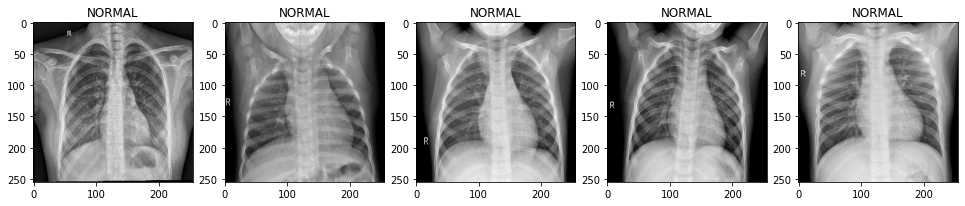

In [9]:
plt.figure(figsize = (20,20))
for i , (img,label) in enumerate(zip(train_list[:5], train_labels[:5])):
    plt.subplot(5,6,i+1)
    plt.imshow(img)
    if label == 0:
        title ="NORMAL"
    elif label == 1:
        title ="PNEUMONIA"
    plt.title(title)

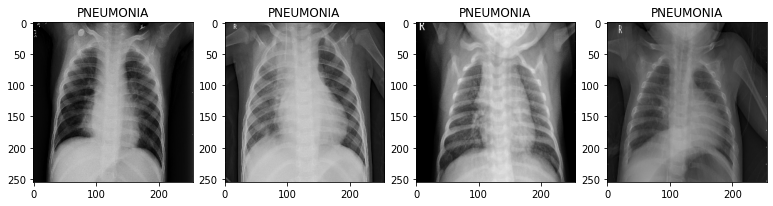

In [10]:
plt.figure(figsize = (20,20))
for i , (img,label) in enumerate(zip(train_list[-5:-1], train_labels[-5:-1])):
    plt.subplot(5,6,i+1)
    plt.imshow(img)
    if label == 0:
        title ="NORMAL"
    elif label == 1:
        title ="PNEUMONIA"
    plt.title(title)

In [11]:
from tensorflow.keras import models, layers, regularizers

# Define a CNN model with L2 regularization and without dropout
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(255, 255, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Show the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stop])


Epoch 1/20
131/131 [==============================] - 179s 1s/step - loss: 0.5410 - accuracy: 0.8214 - val_loss: 0.3366 - val_accuracy: 0.9176
Epoch 2/20
131/131 [==============================] - 170s 1s/step - loss: 0.2390 - accuracy: 0.9528 - val_loss: 0.1321 - val_accuracy: 0.9914
Epoch 3/20
131/131 [==============================] - 165s 1s/step - loss: 0.2208 - accuracy: 0.9564 - val_loss: 0.1334 - val_accuracy: 0.9847
Epoch 4/20
131/131 [==============================] - 157s 1s/step - loss: 0.1965 - accuracy: 0.9602 - val_loss: 0.1731 - val_accuracy: 0.9674
Epoch 5/20
131/131 [==============================] - 157s 1s/step - loss: 0.1543 - accuracy: 0.9708 - val_loss: 0.1259 - val_accuracy: 0.9799
Epoch 6/20
131/131 [==============================] - 157s 1s/step - loss: 0.1404 - accuracy: 0.9734 - val_loss: 0.1218 - val_accuracy: 0.9818
Epoch 7/20
131/131 [==============================] - 152s 1s/step - loss: 0.1431 - accuracy: 0.9724 - val_loss: 0.1020 - val_accuracy: 0.9895

20/20 [==============================] - 6s 270ms/step
Accuracy: 0.7836538461538461
Precision: 0.7495107632093934
Recall: 0.982051282051282
F1 Score: 0.8501664816870145


<Axes: >

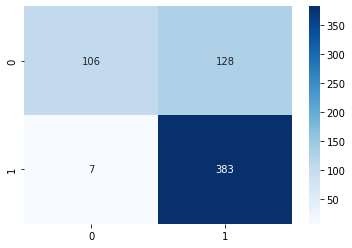

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.85).astype("int32")

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")


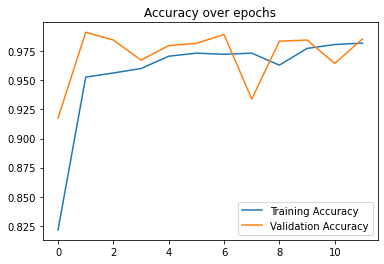

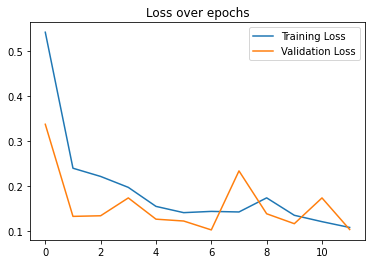

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()


In [27]:
model.save("pneumonia_detection_new_model.h5")
